## Setup

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
keras = tf.keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import jsonpickle
import os
import math
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [13]:
# CONSTANTS

# file paths
root_path = '/content/drive/MyDrive/sisi/'
labels_file = root_path + 'out_labels.json'
data_file =  root_path + 'out_normalized_glyphs.json'

# RNN specific
SHAPE = (784, 1) # best = (784, 1), tried (784, 1), (28, 28), (2, 392) shape of data for RNN

## Loading the data

In [18]:
# LOADING THE LABELS
#
# Usage:
#   labels_str - list of labels in order, as strings: a, a, b, b, c, c...
#   labels_int - list of labels in order, as ints: 0, 0, 1, 1, 2, 2...
#   label_str_dict['a'] returns 0
#   class_names[0] returns 'a'
#   class_amount - total amount of classes (97)

with open(labels_file, 'r') as file:
    labels_str = jsonpickle.decode(file.read())

label_str_dict = {}

def label_str_to_int(label):
    if label not in label_str_dict:
        i = len(label_str_dict)
        label_str_dict[label] = i
    return label_str_dict[label]

labels_int = [ label_str_to_int(label) for label in labels_str ]

class_names = [ list(label_str_dict.keys())[list(label_str_dict.values()).index(i)] for i in range(len(label_str_dict)) ]
class_amount = len(class_names)

# labels_onehot = tf.one_hot(labels_int, depth=class_amount) unused

In [17]:
def split_data(data, labels, idx=100):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for l in range(len(set(labels))):
        label_images = data[labels == l]
        train_data.extend(label_images[:idx])
        train_labels.extend([l]*idx)
        test_data.extend(label_images[idx:])
        test_labels.extend([l]*(len(label_images) - idx))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

In [15]:
def process_data(data):
    data_flattened = [[item for sublist in l for item in sublist] for l in glyphs]
    data_padded = tf.keras.utils.pad_sequences(data_flattened, padding='post', dtype='float32')
    return np.reshape(data_padded, (data_padded.shape[0], SHAPE[0], SHAPE[1]))

In [11]:
with open(data_file, 'r') as file:
    glyphs = (jsonpickle.decode(file.read()))

In [19]:
glyphs_processed = process_data(glyphs)

In [20]:
x_train, y_train, x_test, y_test = split_data(glyphs_processed, np.array(labels_int))

## Creating a model

In [25]:
def dump_res(history):
    print(max(history['val_accuracy']), history['val_accuracy'])
    print(max(history['accuracy']), history['accuracy'])
    print(min(history['val_loss']), history['val_loss'])
    print(min(history['loss']), history['loss'])

In [23]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=SHAPE, dtype="float32"))
 # masking so that GRU knmows zeros are padding
model.add(tf.keras.layers.Masking(mask_value=0.))

# GRU (Gated recurrent unit) - varaint of RNN
model.add(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True))
model.add(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True))
model.add(tf.keras.layers.GRU(256, activation='tanh'))

# classifier 'hat'
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(97, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics=['accuracy']

model.compile(loss=loss, optimizer=optim, metrics=metrics)

## Training a model

In [24]:
batch_size = 64
epochs = 150
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_test, y_test))

Epoch 1/150
152/152 - 27s - loss: 4.4798 - accuracy: 0.0143 - val_loss: 4.2029 - val_accuracy: 0.0211 - 27s/epoch - 179ms/step
Epoch 2/150
152/152 - 9s - loss: 4.1499 - accuracy: 0.0223 - val_loss: 3.9563 - val_accuracy: 0.0366 - 9s/epoch - 58ms/step
Epoch 3/150
152/152 - 9s - loss: 3.8703 - accuracy: 0.0497 - val_loss: 3.4795 - val_accuracy: 0.1021 - 9s/epoch - 62ms/step
Epoch 4/150
152/152 - 9s - loss: 3.3949 - accuracy: 0.1055 - val_loss: 3.0870 - val_accuracy: 0.1649 - 9s/epoch - 62ms/step
Epoch 5/150
152/152 - 9s - loss: 2.9628 - accuracy: 0.1715 - val_loss: 2.7765 - val_accuracy: 0.2459 - 9s/epoch - 57ms/step
Epoch 6/150
152/152 - 10s - loss: 2.4710 - accuracy: 0.2704 - val_loss: 2.2590 - val_accuracy: 0.3675 - 10s/epoch - 63ms/step
Epoch 7/150
152/152 - 9s - loss: 2.0616 - accuracy: 0.3711 - val_loss: 1.8782 - val_accuracy: 0.4464 - 9s/epoch - 62ms/step
Epoch 8/150
152/152 - 9s - loss: 1.7184 - accuracy: 0.4639 - val_loss: 1.5665 - val_accuracy: 0.5572 - 9s/epoch - 57ms/step
Epo

## Training results

In [26]:
dump_res(hist.history)

0.8407216668128967 [0.021134020760655403, 0.03659793734550476, 0.10206185281276703, 0.1649484485387802, 0.245876282453537, 0.36752578616142273, 0.446391761302948, 0.557216465473175, 0.5747422575950623, 0.620103120803833, 0.6726804375648499, 0.6860824823379517, 0.7293814420700073, 0.7489690780639648, 0.7592783570289612, 0.7597938179969788, 0.7742267847061157, 0.7814432978630066, 0.7865979671478271, 0.7860824465751648, 0.7675257921218872, 0.7902061939239502, 0.8041236996650696, 0.7902061939239502, 0.7958762645721436, 0.8077319860458374, 0.803608238697052, 0.8030927777290344, 0.8113402128219604, 0.807216465473175, 0.8077319860458374, 0.8020618557929993, 0.7984536290168762, 0.8211340308189392, 0.811855673789978, 0.8020618557929993, 0.803608238697052, 0.8041236996650696, 0.8046391606330872, 0.8247422575950623, 0.8067010045051575, 0.8144329786300659, 0.8195876479148865, 0.8231958746910095, 0.8087629079818726, 0.7974227070808411, 0.8113402128219604, 0.8061855435371399, 0.8319587707519531, 0.8

In [51]:
#0.8407216668128967 [0.021134020760655403, 0.03659793734550476, 0.10206185281276703, 0.1649484485387802, 0.245876282453537, 0.36752578616142273, 0.446391761302948, 0.557216465473175, 0.5747422575950623, 0.620103120803833, 0.6726804375648499, 0.6860824823379517, 0.7293814420700073, 0.7489690780639648, 0.7592783570289612, 0.7597938179969788, 0.7742267847061157, 0.7814432978630066, 0.7865979671478271, 0.7860824465751648, 0.7675257921218872, 0.7902061939239502, 0.8041236996650696, 0.7902061939239502, 0.7958762645721436, 0.8077319860458374, 0.803608238697052, 0.8030927777290344, 0.8113402128219604, 0.807216465473175, 0.8077319860458374, 0.8020618557929993, 0.7984536290168762, 0.8211340308189392, 0.811855673789978, 0.8020618557929993, 0.803608238697052, 0.8041236996650696, 0.8046391606330872, 0.8247422575950623, 0.8067010045051575, 0.8144329786300659, 0.8195876479148865, 0.8231958746910095, 0.8087629079818726, 0.7974227070808411, 0.8113402128219604, 0.8061855435371399, 0.8319587707519531, 0.8329896926879883, 0.8319587707519531, 0.834536075592041, 0.8139175176620483, 0.8092783689498901, 0.8134020566940308, 0.8206185698509216, 0.803608238697052, 0.8190721869468689, 0.8252577185630798, 0.8180412650108337, 0.8237113356590271, 0.8247422575950623, 0.8113402128219604, 0.8329896926879883, 0.8087629079818726, 0.8170102834701538, 0.8257731795310974, 0.8226804137229919, 0.8257731795310974, 0.8211340308189392, 0.826288640499115, 0.8108247518539429, 0.8077319860458374, 0.8221649527549744, 0.8211340308189392, 0.830927848815918, 0.8180412650108337, 0.8206185698509216, 0.8231958746910095, 0.8304123878479004, 0.8211340308189392, 0.8268041014671326, 0.8298969268798828, 0.8190721869468689, 0.8268041014671326, 0.8206185698509216, 0.8278350234031677, 0.8231958746910095, 0.8195876479148865, 0.8268041014671326, 0.8226804137229919, 0.8376288414001465, 0.8185567259788513, 0.8221649527549744, 0.8257731795310974, 0.8159793615341187, 0.8252577185630798, 0.8154639005661011, 0.8402062058448792, 0.8335051536560059, 0.8175257444381714, 0.8257731795310974, 0.808247447013855, 0.8319587707519531, 0.7969072461128235, 0.8221649527549744, 0.8340206146240234, 0.8128865957260132, 0.8396907448768616, 0.8252577185630798, 0.8113402128219604, 0.8365979194641113, 0.8237113356590271, 0.8247422575950623, 0.8221649527549744, 0.8335051536560059, 0.8010309338569641, 0.8319587707519531, 0.8340206146240234, 0.8216494917869568, 0.8211340308189392, 0.8185567259788513, 0.8154639005661011, 0.8190721869468689, 0.8242267966270447, 0.8211340308189392, 0.8170102834701538, 0.8314433097839355, 0.8170102834701538, 0.8396907448768616, 0.8376288414001465, 0.8293814659118652, 0.820103108882904, 0.8252577185630798, 0.8278350234031677, 0.830927848815918, 0.834536075592041, 0.8237113356590271, 0.8293814659118652, 0.8252577185630798, 0.8273195624351501, 0.8226804137229919, 0.8304123878479004, 0.8278350234031677, 0.830927848815918, 0.8407216668128967, 0.826288640499115, 0.8298969268798828, 0.834536075592041, 0.826288640499115]
#0.9829896688461304 [0.014329897239804268, 0.022268041968345642, 0.04969072341918945, 0.1054639145731926, 0.17154638469219208, 0.2704123854637146, 0.3711340129375458, 0.4639175236225128, 0.5368041396141052, 0.5986598134040833, 0.6458762884140015, 0.6791752576828003, 0.7151546478271484, 0.7478350400924683, 0.7665979266166687, 0.7856701016426086, 0.8046391606330872, 0.8132989406585693, 0.8261855840682983, 0.8331958651542664, 0.839175283908844, 0.8422680497169495, 0.8479381203651428, 0.8583505153656006, 0.8678350448608398, 0.8711340427398682, 0.8721649646759033, 0.8824742436408997, 0.8852577209472656, 0.8842267990112305, 0.8852577209472656, 0.8886597752571106, 0.8942267894744873, 0.9020618796348572, 0.8976288437843323, 0.895566999912262, 0.9027835130691528, 0.9050515294075012, 0.9059793949127197, 0.9104123711585999, 0.9095876216888428, 0.9142268300056458, 0.91484534740448, 0.9174226522445679, 0.9161855578422546, 0.9155669808387756, 0.9261855483055115, 0.9205154776573181, 0.9180412292480469, 0.9321649670600891, 0.9285566806793213, 0.9325773119926453, 0.9288659691810608, 0.9330927729606628, 0.9288659691810608, 0.9335051774978638, 0.9304123520851135, 0.9338144063949585, 0.9398968815803528, 0.9418556690216064, 0.9410309195518494, 0.9372165203094482, 0.9456701278686523, 0.9332989454269409, 0.9425773024559021, 0.9488659501075745, 0.9459793567657471, 0.9452577233314514, 0.9418556690216064, 0.9444329738616943, 0.951237142086029, 0.9536082744598389, 0.9377319812774658, 0.9509278535842896, 0.9515463709831238, 0.9494845271110535, 0.9547422528266907, 0.9410309195518494, 0.9588660001754761, 0.9526804089546204, 0.9515463709831238, 0.9492783546447754, 0.961443305015564, 0.9562886357307434, 0.9589690566062927, 0.9545360803604126, 0.9612371325492859, 0.954020619392395, 0.9532989859580994, 0.962061882019043, 0.9605154395103455, 0.9598969221115112, 0.9630928039550781, 0.9589690566062927, 0.966288685798645, 0.9671133756637573, 0.9528865814208984, 0.9617525935173035, 0.9552577137947083, 0.9670103192329407, 0.9655669927597046, 0.965670108795166, 0.9588660001754761, 0.9625773429870605, 0.9561855792999268, 0.9601030945777893, 0.9682474136352539, 0.9750515222549438, 0.9693814516067505, 0.9691752791404724, 0.9706185460090637, 0.9677319526672363, 0.9675257802009583, 0.973917543888092, 0.9709278345108032, 0.956804096698761, 0.9586597681045532, 0.9698969125747681, 0.9755669832229614, 0.973917543888092, 0.9727835059165955, 0.9741237163543701, 0.9685567021369934, 0.9744330048561096, 0.9705154895782471, 0.9721649289131165, 0.9682474136352539, 0.9712371230125427, 0.9735051393508911, 0.9786598086357117, 0.9788659811019897, 0.9787628650665283, 0.9668041467666626, 0.9754639267921448, 0.9788659811019897, 0.9715464115142822, 0.9762886762619019, 0.9785566926002502, 0.9760825037956238, 0.9680412411689758, 0.9791752696037292, 0.973092794418335, 0.9692783355712891, 0.9783505201339722, 0.9693814516067505, 0.9791752696037292, 0.9749484658241272, 0.9756700992584229, 0.9829896688461304, 0.9784536361694336]
#0.8209063410758972 [4.202883243560791, 3.9563188552856445, 3.4794883728027344, 3.0869548320770264, 2.776524305343628, 2.2590184211730957, 1.878170371055603, 1.5665018558502197, 1.5259894132614136, 1.3680050373077393, 1.1779974699020386, 1.139890193939209, 1.026563286781311, 0.9747373461723328, 0.8921056985855103, 0.920158326625824, 0.9093173146247864, 0.8806358575820923, 0.8630427718162537, 0.8741892576217651, 0.95704185962677, 0.8539046049118042, 0.8237531781196594, 0.9036250710487366, 0.906753659248352, 0.8650146722793579, 0.8615186810493469, 0.8395642042160034, 0.9005897045135498, 0.8209063410758972, 0.8752256631851196, 0.9463258385658264, 0.925432026386261, 0.9181435108184814, 0.8863506317138672, 1.0063014030456543, 0.9529697895050049, 0.9911734461784363, 0.9705538749694824, 0.8922694325447083, 0.9633781909942627, 0.8845410943031311, 0.9379183650016785, 0.9359664916992188, 0.991584837436676, 1.0692423582077026, 1.031569480895996, 0.9876220226287842, 0.9001299738883972, 0.9283906817436218, 0.9147279262542725, 0.9565439224243164, 1.0239369869232178, 1.0947257280349731, 0.983393669128418, 1.0199910402297974, 1.032875657081604, 0.9907891154289246, 1.000414252281189, 1.1111195087432861, 0.9965031147003174, 0.9985440969467163, 1.0946929454803467, 0.9374880790710449, 1.1184896230697632, 1.0767229795455933, 1.0720741748809814, 1.0827556848526, 1.0384520292282104, 1.0267413854599, 1.0703842639923096, 1.1583642959594727, 1.0719043016433716, 1.0747634172439575, 1.1189520359039307, 1.0681097507476807, 1.1360108852386475, 1.0474480390548706, 1.1286978721618652, 1.0734361410140991, 1.1217968463897705, 1.0814579725265503, 1.104889988899231, 1.193721055984497, 1.2281461954116821, 1.179457426071167, 1.1361674070358276, 1.1841574907302856, 1.2138357162475586, 1.1742573976516724, 1.2389310598373413, 1.1144499778747559, 1.1917526721954346, 1.186914324760437, 1.204583764076233, 1.265007495880127, 1.1412698030471802, 1.2249144315719604, 1.1231186389923096, 1.1296703815460205, 1.2880257368087769, 1.225251317024231, 1.2208452224731445, 1.1646369695663452, 1.3915839195251465, 1.1894465684890747, 1.125745415687561, 1.310524821281433, 1.2277140617370605, 1.3067855834960938, 1.230472207069397, 1.1854723691940308, 1.2574336528778076, 1.2428646087646484, 1.3370685577392578, 1.1174136400222778, 1.292737603187561, 1.1902565956115723, 1.1736969947814941, 1.2050279378890991, 1.2962743043899536, 1.2702264785766602, 1.236772894859314, 1.317391276359558, 1.1964937448501587, 1.2707022428512573, 1.2122933864593506, 1.2315857410430908, 1.3269294500350952, 1.2967532873153687, 1.218796968460083, 1.3478411436080933, 1.316800832748413, 1.2825043201446533, 1.341284990310669, 1.2127165794372559, 1.272437334060669, 1.3222602605819702, 1.275723934173584, 1.4160488843917847, 1.3395147323608398, 1.334949254989624, 1.2501256465911865, 1.3414933681488037, 1.2979178428649902, 1.2728716135025024, 1.3083668947219849, 1.3132643699645996, 1.3173431158065796, 1.4358649253845215]
#0.052261751145124435 [4.479824542999268, 4.149890422821045, 3.8702895641326904, 3.3949294090270996, 2.962826728820801, 2.4709794521331787, 2.0615971088409424, 1.7183690071105957, 1.4533668756484985, 1.238604187965393, 1.0763217210769653, 0.9758046269416809, 0.8618523478507996, 0.7717720866203308, 0.6903159022331238, 0.6261663436889648, 0.5781403183937073, 0.5377873778343201, 0.4982674717903137, 0.47508296370506287, 0.44822070002555847, 0.4359915256500244, 0.42132568359375, 0.3816257119178772, 0.36135271191596985, 0.3555854558944702, 0.33685964345932007, 0.32593193650245667, 0.3107450008392334, 0.30703967809677124, 0.3101934492588043, 0.2968601882457733, 0.2759920060634613, 0.26459166407585144, 0.2598816156387329, 0.2785036265850067, 0.2654182016849518, 0.2525686025619507, 0.2602580487728119, 0.23445118963718414, 0.24458836019039154, 0.2270589917898178, 0.2224537879228592, 0.21421165764331818, 0.21982160210609436, 0.22992652654647827, 0.20416800677776337, 0.21641254425048828, 0.22089773416519165, 0.17283722758293152, 0.1883222758769989, 0.17658059298992157, 0.19259941577911377, 0.18164478242397308, 0.19396278262138367, 0.17130565643310547, 0.190998375415802, 0.17268610000610352, 0.16593782603740692, 0.14866892993450165, 0.1546688675880432, 0.1606815606355667, 0.15665243566036224, 0.18972931802272797, 0.14591220021247864, 0.14302009344100952, 0.15373949706554413, 0.14883215725421906, 0.1601644605398178, 0.14273695647716522, 0.13885663449764252, 0.12468196451663971, 0.17785771191120148, 0.13071593642234802, 0.13324522972106934, 0.13627400994300842, 0.12347685545682907, 0.17480535805225372, 0.10865085572004318, 0.13784177601337433, 0.14533397555351257, 0.13772597908973694, 0.11528415977954865, 0.117657370865345, 0.10889358073472977, 0.13222333788871765, 0.10371173173189163, 0.1430625319480896, 0.13448995351791382, 0.10151679813861847, 0.10743398219347, 0.11650165170431137, 0.11332742124795914, 0.11852701753377914, 0.09341779351234436, 0.08765275031328201, 0.13613323867321014, 0.10796326398849487, 0.12629301846027374, 0.09588039666414261, 0.09263050556182861, 0.10485059022903442, 0.11555948108434677, 0.10892362892627716, 0.1327936053276062, 0.12275794893503189, 0.08909402787685394, 0.07109842449426651, 0.0855017751455307, 0.0840214267373085, 0.09665337204933167, 0.09609668701887131, 0.09012439846992493, 0.07324090600013733, 0.07957392930984497, 0.13589513301849365, 0.1321435421705246, 0.09273837506771088, 0.06839236617088318, 0.07728725671768188, 0.08312518149614334, 0.07088030129671097, 0.10026595741510391, 0.07355118542909622, 0.08892806619405746, 0.083468958735466, 0.09517740458250046, 0.08833788335323334, 0.0807715430855751, 0.06691215187311172, 0.06482256948947906, 0.06487113982439041, 0.11322561651468277, 0.07891209423542023, 0.061799127608537674, 0.08917224407196045, 0.06813055276870728, 0.06944341957569122, 0.0727439746260643, 0.0897202268242836, 0.05606454610824585, 0.08838354796171188, 0.09170214831829071, 0.06852700561285019, 0.09096921235322952, 0.0596628338098526, 0.08305728435516357, 0.07356081902980804, 0.052261751145124435, 0.0663381963968277]

In [65]:
def plot_acc(train_acc, val_acc):
    plt.figure(figsize=(10, 5), dpi=100)
    epochs = np.arange(len(train_acc))
    plt.xlim([1, len(train_acc)])
    plt.ylim([0, 1])
    plt.xlabel("Numer epoki")
    polish_name= 'Dokładność '
    plt.ylabel("Wartość dokładności")
    plt.plot(epochs, train_acc, label="Dokładność dla zb. treningowego")
    plt.plot(epochs, val_acc, label="Dokładność dla zb. testowego")
    plt.title("Sieć zawierająca rekurencyjne jednostki neuronowe z bramkami - dokładność")
    plt.legend(loc='lower right', bbox_to_anchor=(1, -0.25))
    plt.show()

def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 5), dpi=100)
    epochs = np.arange(len(train_loss))
    plt.xlim([1, len(train_loss)])
    plt.ylim([0, 1.5])
    plt.xlabel("Numer epoki")
    polish_name= 'Funkcja kosztu'
    plt.ylabel("Wartość funkcji kosztu")
    plt.plot(epochs, train_loss, label="Funkcja kosztu dla zb. treningowego")
    plt.plot(epochs, val_loss, label="Funkcja kosztu dla zb. testowego")
    plt.title("Sieć zawierająca rekurencyjne jednostki neuronowe z bramkami - funkcja kosztu")
    plt.legend(loc='lower right', bbox_to_anchor=(1, -0.25))
    plt.show()

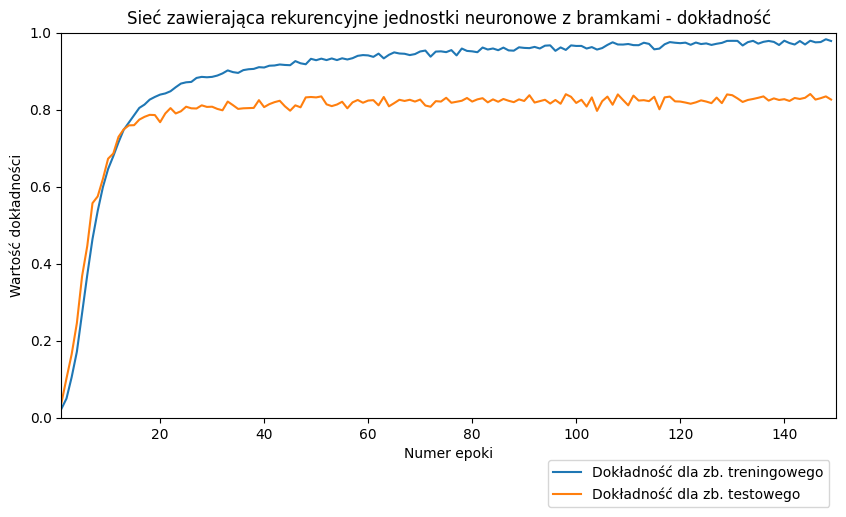

In [66]:
plot_acc(hist.history["accuracy"], hist.history["val_accuracy"])

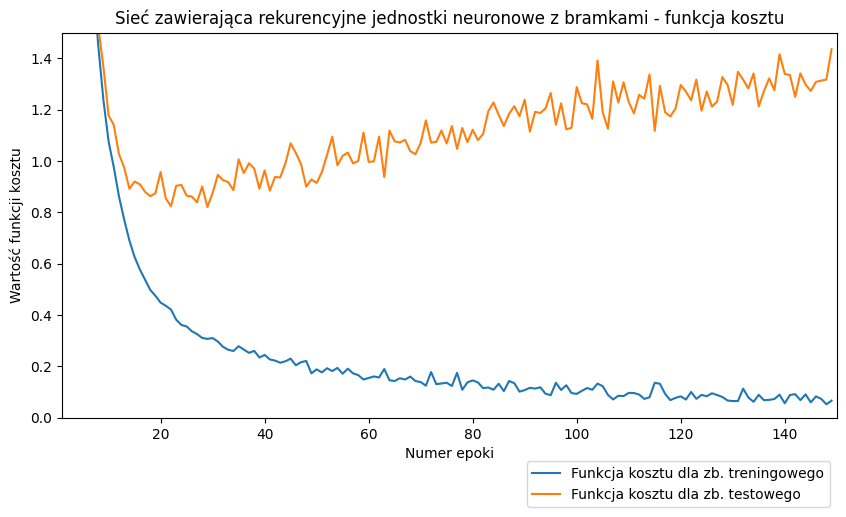

In [64]:
plot_loss(hist.history["loss"], hist.history["val_loss"])